![logo](JFM-notebooks-logo.jpg)



### Description:

The TRIS concept is applied to an open\-channel flow configuration. Variables are non\-dimensionalized by the friction velocity and height of the open\-channel. The streamwise, spanwise, and wall\-normal components are \(x,y,z\) and \(u,v,w\), respectively. The boundary conditions are periodic in the x and z directions. At y=0, a no\-slip and no\-penetration boundary condition is applied and at y=1, a no\-vorticity and no\-penetration boundary condition is applied.



### Loading TRIS Modules / Input Parameters:



In [3]:
from periodic2d import *
from tris_models import *
from IPython.display import Image
import time

# Setup
Lx  = 8*pi                 # domain size in x-direction (streamwise)
Lz  = 3*pi                 # domain size in y-direction (spanwise)
nx  = 128                  # number of grid points in x
nz  = 48                   # number of grid points in y
CFL = 0.05                 # CFL number (stable time step)
num_TT = 1.                # number of turnover times (for equivalent 4pi domain)
init_noise = 2e-1          # meandering magnitude

# Animation Option
n_report = 5               # n snapshots per turnover time
animation_variable = 'u0'  # Choose variable for animation: 'u0', 'u1', 'w0', 'w1', 'v0', 'p0', or 'p1'

# Set any model parameters different from defaults
params = Params()
params.Re  = 395.          # friction Reynolds number
params.Cuv = 0.540         # wall-normal eddy viscosity coeff
params.Cs0 = 0.78          # wall-parallel eddy viscosity coeff (Zeroth Moment)
params.Cs1 = 0.78          # wall-parallel eddy viscosity coeff (First Moment)
params.Pi_ref = 0.203      # reference wake parameter
params.B = 4.97            # Log offset
params.CPi = 2.68          # Reynolds shear stress

### Initializing Fields:



In [4]:
# SOLUTION VARIABLES 
msh = Msh(Lx, Lz, nx, nz)
u0 = Var(msh, name='u0')    # <u>_0, zeroth moment of streamwise velocity
w0 = Var(msh, name='w0')    # <w>_0, zeroth moment of spanwise velocity
u1 = Var(msh, name='u1')    # <u>_1, first moment of spanwise velocity
w1 = Var(msh, name='w1')    # <w>_1, first moment of spanwise velocity

# HELPER VARIABLES 
v0 = Var(msh)    # <v>_0, zeroth moment of wall-normal velocity
p0 = Var(msh)    # <p>_0, zeroth moment of pressure
p1 = Var(msh)    # <p>_1, first moment of pressure

# INITIALIZE WITH RESTART FILE
restart_data = np.load('snapshot1.npy')
u0_restart = restart_data[:,:,0]
u1_restart = restart_data[:,:,1]
w0_restart = restart_data[:,:,2]
w1_restart = restart_data[:,:,3]

u0 = Var(u0.msh, val=u0_restart)
w0 = Var(w0.msh, val=w0_restart)
u1 = Var(u1.msh, val=u1_restart)
w1 = Var(w1.msh, val=w1_restart)

# project to divergence free
for field in [u0,u1,w0,w1]:
  field.fft()
(u0, w0) = projection(u0, w0)
for field in [u0, w0, u1, w1]:
  field.ifft()

### Run TRIS:



Turnover times complete: 0.0 


Turnover times complete: 0.2 


Turnover times complete: 0.4 


Turnover times complete: 0.6 


Turnover times complete: 0.8 


Turnover times complete: 1.0 


TRIS simulation time: 73.0 seconds


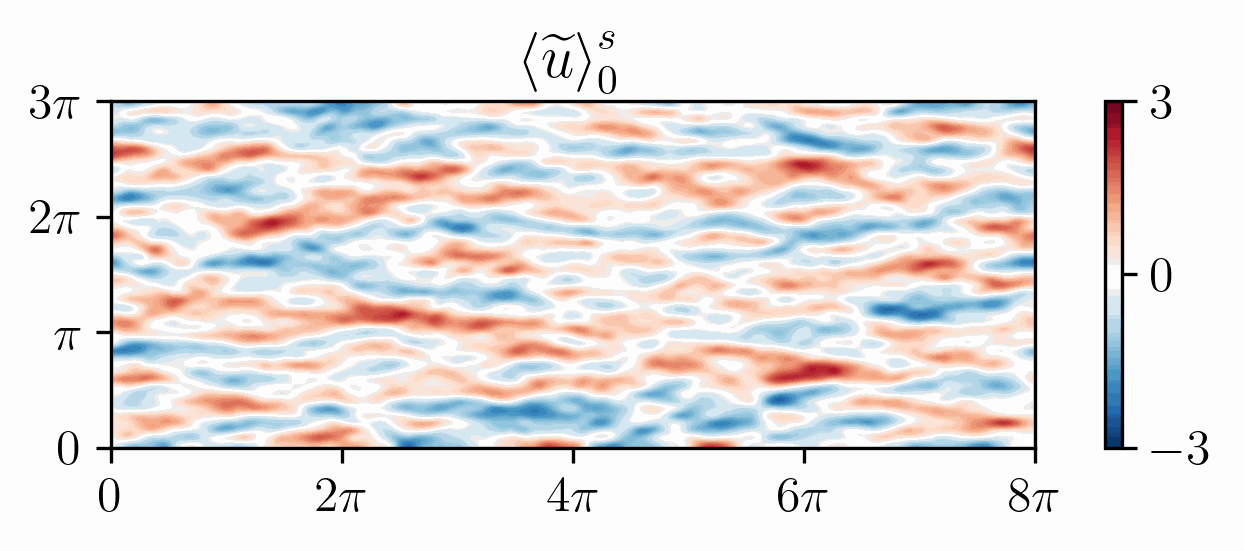

In [5]:
# Take Timestep
dt = CFL * msh.dx / np.sqrt(np.max(u0.val**2 + w0.val**2))
TT = 1.
DT = num_TT * TT
num_steps = int(DT/dt)
report_incr = int((1/n_report)*TT/dt)

# Initialize Animation
animation = Animation(animation_variable, 'animation/')

# Initialize Counter
i = 0

sim_start_time = time.time()

for n in range(num_steps+1):
  # take a RK2 step
  # predictor step 
  (pre_u0, pre_w0, pre_u1, pre_w1, p0, p1) = calc_rhs(u0, w0, u1, w1, params)
  p = 0.5 # 1.0 for predictor-corrector, 0.5 for midpoint
  u0_mid = u0.add(pre_u0.smult(p*dt)) 
  w0_mid = w0.add(pre_w0.smult(p*dt)) 
  u1_mid = u1.add(pre_u1.smult(p*dt)) 
  w1_mid = w1.add(pre_w1.smult(p*dt))
  
  # corrector step
  (cor_u0, cor_w0, cor_u1, cor_w1, p0, p1) = calc_rhs(u0_mid, w0_mid, u1_mid, w1_mid, params)
  q = 1/(2*p)
  u0 = u0.add(pre_u0.smult((1-q)*dt)).add(cor_u0.smult(q*dt)) 
  w0 = w0.add(pre_w0.smult((1-q)*dt)).add(cor_w0.smult(q*dt)) 
  u1 = u1.add(pre_u1.smult((1-q)*dt)).add(cor_u1.smult(q*dt)) 
  w1 = w1.add(pre_w1.smult((1-q)*dt)).add(cor_w1.smult(q*dt)) 

  # update pressure based on corrected velocity
  (cor_u0, cor_w0, cor_u1, cor_w1, p0, p1) = calc_rhs(u0, w0, u1, w1, params)

  # data processing
  if(np.mod(n,report_incr)==0):
    t = n*dt
    print(f"Turnover times complete: {t/TT:.1f} ", flush=True)
    #
    error = div(u0, w0)
    v0 = calc_v0(u1, w1)
    v0.ifft()
    p0.ifft()
    p1.ifft()

    if animation_variable == 'u0':
      input_field = u0
    elif animation_variable == 'u1':
      input_field = u1
    elif animation_variable == 'w0':
      input_field = w0
    elif animation_variable == 'w1':
      input_field = w1
    elif animation_variable == 'v0':
      input_field = v0
    elif animation_variable == 'p0':
      input_field = p0
    elif animation_variable == 'p1':
      input_field = p1
    #
    animation.update(i, input_field)

    i+= 1
    
sim_end_time = time.time()
elapsed_time = sim_end_time - sim_start_time
print(f"TRIS simulation time: {elapsed_time:.1f} seconds", flush=True)

animation.compile(animation_variable)
display(Image(filename='animation/'+animation_variable+'.gif'))